<a href="https://colab.research.google.com/github/DrVenkataRajeshKumar/S10/blob/master/S10f9.5min.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
!git clone https://github.com/DrVenkataRajeshKumar/EVA4Library.git
import sys
sys.path.append("/content/EVA4_LIBRARY/EVA4")

fatal: destination path 'EVA4Library' already exists and is not an empty directory.


In [84]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-651z1hn2
All libraries are successfully installed!


In [85]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)

Files already downloaded and verified


In [86]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))
print(mu, sq/n, std, n)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


In [0]:
# add path to our library in default search path
import sys
sys.path.append('/content/drive/My Drive/EVA4')

In [0]:

import numpy as np
#import eva4datatransforms as eva4datatransforms
from torchvision import transforms
from eva4albumentations import Albumentations
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
norm_mean_std=[channel_means,channel_stdevs]
# Train Phase transformations
train_transforms = Albumentations(norm_mean_std,Rotate=(-30,30),HorizontalFlip=True,RGBshift=(50,50,50),cutout=(3,))

# Test Phase transformations
test_transforms = Albumentations(norm_mean_std)

In [89]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import eva4dataloaders

dataloader = eva4dataloaders.DataLoader(batch_size=128)

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

torch.Size([128, 3, 32, 32])
torch.Size([128])


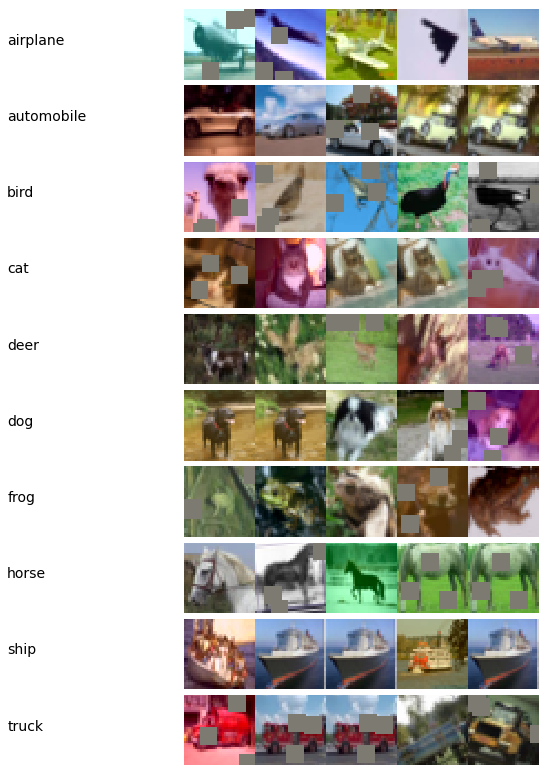

In [91]:
from __future__ import print_function
def unnormalize(img):
  img = img.cpu().numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [92]:
import rn
import torch
model = rn.ResNet18()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



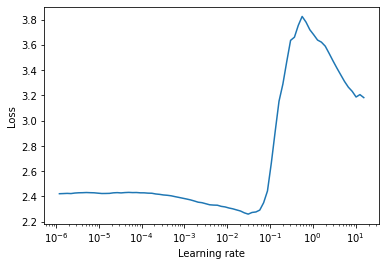

In [93]:
# LR finder fast ai approach
from lrfinder import LRFinder
import torch.optim as optim
import torch.nn as nn
L1lambda = 0
L2lambda = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, nesterov=True, weight_decay=L2lambda)
lr_finder = LRFinder(model, optimizer, criterion, device=model.device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [0]:
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']
#lr[loss.index(min(loss))]
optimizer = optim.SGD(model.parameters(), lr=lr[loss.index(min(loss))], momentum=0.9, nesterov=True, weight_decay=L2lambda)

In [95]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
EPOCHS = 50
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)

scheduler = ReduceLROnPlateau(optimizer, min_lr=1e-7, mode='max', factor=0.95, patience=1, verbose=True)

model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, False, L1lambda)


Validation loss decreased (100000.000000 --> 1.158118).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0123, Accuracy: 43.40%; Test set: Average loss: 1.1581, Accuracy: 59.29%
Learning Rate = 0.030903



Validation loss decreased (1.158118 --> 1.065385).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0085, Accuracy: 61.85%; Test set: Average loss: 1.0654, Accuracy: 66.55%
Learning Rate = 0.030903



Epoch     3: reducing learning rate of group 0 to 2.9358e-02.
Validation loss decreased (1.065385 --> 0.736457).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0069, Accuracy: 69.29%; Test set: Average loss: 0.7365, Accuracy: 74.98%
Learning Rate = 0.029358



Validation loss decreased (0.736457 --> 0.654273).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0060, Accuracy: 73.25%; Test set: Average loss: 0.6543, Accuracy: 77.54%
Learning Rate = 0.029358



Epoch     5: reducing learning rate of group 0 to 2.7890e-02.
Validation loss decreased (0.654273 --> 0.605226).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0053, Accuracy: 76.36%; Test set: Average loss: 0.6052, Accuracy: 79.70%
Learning Rate = 0.027890



Validation loss decreased (0.605226 --> 0.554008).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0048, Accuracy: 78.92%; Test set: Average loss: 0.5540, Accuracy: 81.07%
Learning Rate = 0.027890



Epoch     7: reducing learning rate of group 0 to 2.6495e-02.
Validation loss decreased (0.554008 --> 0.534971).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0045, Accuracy: 80.34%; Test set: Average loss: 0.5350, Accuracy: 82.02%
Learning Rate = 0.026495



Validation loss decreased (0.534971 --> 0.455602).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0041, Accuracy: 81.86%; Test set: Average loss: 0.4556, Accuracy: 84.82%
Learning Rate = 0.026495



Epoch     9: reducing learning rate of group 0 to 2.5171e-02.
Validation loss decreased (0.455602 --> 0.433357).  Saving model ...
Epoch: 9, Train set: Average loss: 0.0038, Accuracy: 83.08%; Test set: Average loss: 0.4334, Accuracy: 85.18%
Learning Rate = 0.025171



Epoch: 10, Train set: Average loss: 0.0035, Accuracy: 84.36%; Test set: Average loss: 0.4596, Accuracy: 84.91%
Learning Rate = 0.025171



Epoch    11: reducing learning rate of group 0 to 2.3912e-02.
Epoch: 11, Train set: Average loss: 0.0034, Accuracy: 85.20%; Test set: Average loss: 0.4524, Accuracy: 84.86%
Learning Rate = 0.023912



Epoch: 12, Train set: Average loss: 0.0031, Accuracy: 86.21%; Test set: Average loss: 0.5111, Accuracy: 83.54%
Learning Rate = 0.023912



Epoch    13: reducing learning rate of group 0 to 2.2717e-02.
Validation loss decreased (0.433357 --> 0.404042).  Saving model ...
Epoch: 13, Train set: Average loss: 0.0030, Accuracy: 86.60%; Test set: Average loss: 0.4040, Accuracy: 86.16%
Learning Rate = 0.022717



Validation loss decreased (0.404042 --> 0.381920).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0028, Accuracy: 87.30%; Test set: Average loss: 0.3819, Accuracy: 87.23%
Learning Rate = 0.022717



Epoch    15: reducing learning rate of group 0 to 2.1581e-02.
Epoch: 15, Train set: Average loss: 0.0026, Accuracy: 88.35%; Test set: Average loss: 0.3831, Accuracy: 87.73%
Learning Rate = 0.021581



Validation loss decreased (0.381920 --> 0.357710).  Saving model ...
Epoch: 16, Train set: Average loss: 0.0026, Accuracy: 88.74%; Test set: Average loss: 0.3577, Accuracy: 88.51%
Learning Rate = 0.021581



Epoch    17: reducing learning rate of group 0 to 2.0502e-02.
Epoch: 17, Train set: Average loss: 0.0024, Accuracy: 89.40%; Test set: Average loss: 0.3579, Accuracy: 88.32%
Learning Rate = 0.020502



Epoch: 18, Train set: Average loss: 0.0022, Accuracy: 89.95%; Test set: Average loss: 0.3933, Accuracy: 87.86%
Learning Rate = 0.020502



Epoch    19: reducing learning rate of group 0 to 1.9477e-02.
Epoch: 19, Train set: Average loss: 0.0022, Accuracy: 90.19%; Test set: Average loss: 0.3717, Accuracy: 88.18%
Learning Rate = 0.019477



Epoch: 20, Train set: Average loss: 0.0020, Accuracy: 90.92%; Test set: Average loss: 0.3603, Accuracy: 89.16%
Learning Rate = 0.019477



Epoch    21: reducing learning rate of group 0 to 1.8503e-02.
Validation loss decreased (0.357710 --> 0.321146).  Saving model ...
Epoch: 21, Train set: Average loss: 0.0020, Accuracy: 91.25%; Test set: Average loss: 0.3211, Accuracy: 89.76%
Learning Rate = 0.018503



Epoch: 22, Train set: Average loss: 0.0019, Accuracy: 91.64%; Test set: Average loss: 0.3361, Accuracy: 89.34%
Learning Rate = 0.018503



Epoch    23: reducing learning rate of group 0 to 1.7578e-02.
Epoch: 23, Train set: Average loss: 0.0018, Accuracy: 92.15%; Test set: Average loss: 0.3221, Accuracy: 89.70%
Learning Rate = 0.017578



Epoch: 24, Train set: Average loss: 0.0017, Accuracy: 92.43%; Test set: Average loss: 0.3237, Accuracy: 89.68%
Learning Rate = 0.017578



Epoch    25: reducing learning rate of group 0 to 1.6699e-02.
Epoch: 25, Train set: Average loss: 0.0017, Accuracy: 92.56%; Test set: Average loss: 0.3717, Accuracy: 88.53%
Learning Rate = 0.016699



Epoch: 26, Train set: Average loss: 0.0015, Accuracy: 93.18%; Test set: Average loss: 0.3219, Accuracy: 89.95%
Learning Rate = 0.016699



Epoch    27: reducing learning rate of group 0 to 1.5864e-02.
Validation loss decreased (0.321146 --> 0.295919).  Saving model ...
Epoch: 27, Train set: Average loss: 0.0015, Accuracy: 93.19%; Test set: Average loss: 0.2959, Accuracy: 90.84%
Learning Rate = 0.015864



Epoch: 28, Train set: Average loss: 0.0014, Accuracy: 93.90%; Test set: Average loss: 0.3041, Accuracy: 90.82%
Learning Rate = 0.015864



Epoch    29: reducing learning rate of group 0 to 1.5071e-02.
Epoch: 29, Train set: Average loss: 0.0014, Accuracy: 93.82%; Test set: Average loss: 0.3582, Accuracy: 89.55%
Learning Rate = 0.015071



Epoch: 30, Train set: Average loss: 0.0014, Accuracy: 94.02%; Test set: Average loss: 0.3310, Accuracy: 90.23%
Learning Rate = 0.015071



Epoch    31: reducing learning rate of group 0 to 1.4317e-02.
Epoch: 31, Train set: Average loss: 0.0013, Accuracy: 94.20%; Test set: Average loss: 0.3235, Accuracy: 90.30%
Learning Rate = 0.014317



Epoch: 32, Train set: Average loss: 0.0013, Accuracy: 94.45%; Test set: Average loss: 0.3430, Accuracy: 90.35%
Learning Rate = 0.014317



Epoch    33: reducing learning rate of group 0 to 1.3601e-02.
Epoch: 33, Train set: Average loss: 0.0012, Accuracy: 94.85%; Test set: Average loss: 0.3088, Accuracy: 90.74%
Learning Rate = 0.013601



Epoch: 34, Train set: Average loss: 0.0012, Accuracy: 94.99%; Test set: Average loss: 0.3017, Accuracy: 90.67%
Learning Rate = 0.013601



Epoch    35: reducing learning rate of group 0 to 1.2921e-02.
Validation loss decreased (0.295919 --> 0.292708).  Saving model ...
Epoch: 35, Train set: Average loss: 0.0011, Accuracy: 94.98%; Test set: Average loss: 0.2927, Accuracy: 91.42%
Learning Rate = 0.012921



Validation loss decreased (0.292708 --> 0.291156).  Saving model ...
Epoch: 36, Train set: Average loss: 0.0011, Accuracy: 95.24%; Test set: Average loss: 0.2912, Accuracy: 91.41%
Learning Rate = 0.012921



Epoch    37: reducing learning rate of group 0 to 1.2275e-02.
Validation loss decreased (0.291156 --> 0.290708).  Saving model ...
Epoch: 37, Train set: Average loss: 0.0011, Accuracy: 95.34%; Test set: Average loss: 0.2907, Accuracy: 91.42%
Learning Rate = 0.012275



Validation loss decreased (0.290708 --> 0.287081).  Saving model ...
Epoch: 38, Train set: Average loss: 0.0010, Accuracy: 95.67%; Test set: Average loss: 0.2871, Accuracy: 91.69%
Learning Rate = 0.012275



Epoch    39: reducing learning rate of group 0 to 1.1661e-02.
Epoch: 39, Train set: Average loss: 0.0010, Accuracy: 95.79%; Test set: Average loss: 0.2974, Accuracy: 91.50%
Learning Rate = 0.011661



Epoch: 40, Train set: Average loss: 0.0009, Accuracy: 95.88%; Test set: Average loss: 0.2954, Accuracy: 91.66%
Learning Rate = 0.011661



Epoch    41: reducing learning rate of group 0 to 1.1078e-02.
Epoch: 41, Train set: Average loss: 0.0009, Accuracy: 96.04%; Test set: Average loss: 0.3001, Accuracy: 91.31%
Learning Rate = 0.011078



Epoch: 42, Train set: Average loss: 0.0009, Accuracy: 96.00%; Test set: Average loss: 0.3005, Accuracy: 91.13%
Learning Rate = 0.011078



Epoch    43: reducing learning rate of group 0 to 1.0524e-02.
Epoch: 43, Train set: Average loss: 0.0009, Accuracy: 96.07%; Test set: Average loss: 0.3130, Accuracy: 91.28%
Learning Rate = 0.010524



Epoch: 44, Train set: Average loss: 0.0008, Accuracy: 96.60%; Test set: Average loss: 0.3048, Accuracy: 91.49%
Learning Rate = 0.010524



Epoch    45: reducing learning rate of group 0 to 9.9981e-03.
Epoch: 45, Train set: Average loss: 0.0008, Accuracy: 96.42%; Test set: Average loss: 0.2965, Accuracy: 91.88%
Learning Rate = 0.009998



Validation loss decreased (0.287081 --> 0.283815).  Saving model ...
Epoch: 46, Train set: Average loss: 0.0008, Accuracy: 96.53%; Test set: Average loss: 0.2838, Accuracy: 92.31%
Learning Rate = 0.009998



Epoch    47: reducing learning rate of group 0 to 9.4982e-03.
Epoch: 47, Train set: Average loss: 0.0008, Accuracy: 96.63%; Test set: Average loss: 0.2901, Accuracy: 91.76%
Learning Rate = 0.009498



Epoch: 48, Train set: Average loss: 0.0007, Accuracy: 96.78%; Test set: Average loss: 0.2937, Accuracy: 92.00%
Learning Rate = 0.009498



Epoch    49: reducing learning rate of group 0 to 9.0233e-03.
Epoch: 49, Train set: Average loss: 0.0007, Accuracy: 96.76%; Test set: Average loss: 0.2862, Accuracy: 92.16%
Learning Rate = 0.009023



Epoch: 50, Train set: Average loss: 0.0007, Accuracy: 97.04%; Test set: Average loss: 0.3002, Accuracy: 91.94%
Learning Rate = 0.009023



In [96]:
print(max(model.stats().train_acc))
print(max(model.stats().test_acc))

0.97038
0.9231


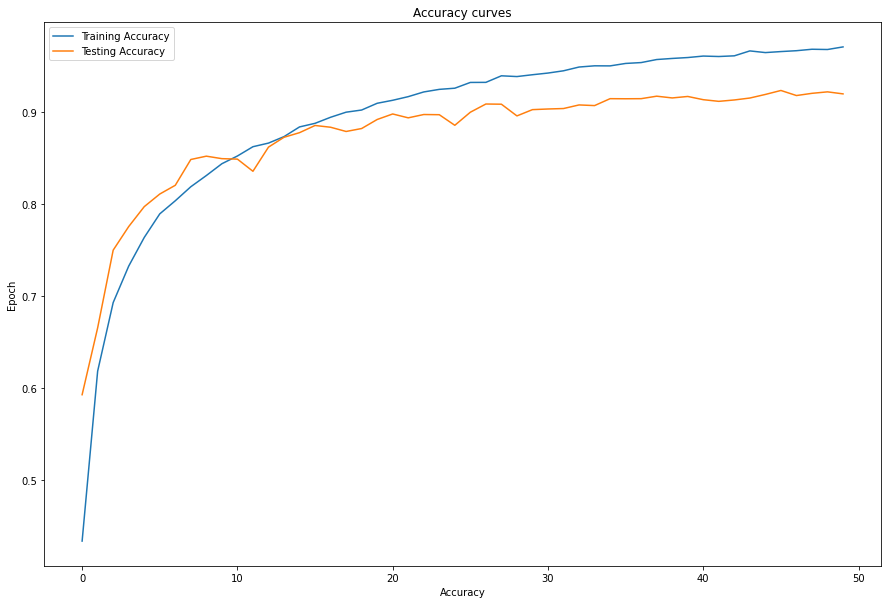

In [97]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(model.stats().train_acc)
ax.plot(model.stats().test_acc)

ax.set(title="Accuracy curves", xlabel="Accuracy", ylabel="Epoch")
ax.legend(['Training Accuracy', 'Testing Accuracy'], loc='best')
plt.savefig("TrainTestAccuracy.png")
plt.show()

In [98]:
len(model.stats().get_misclassified_images())

25

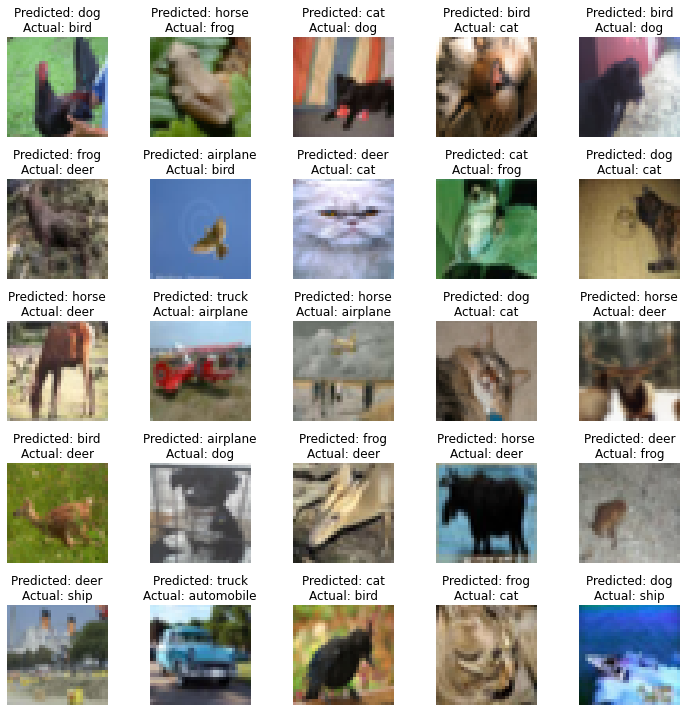

In [99]:
import plots

plots.plot_images(model.stats().get_misclassified_images(), class_names, "misclassified_imgs.png", mean=list(channel_means), std=list(channel_stdevs))

In [0]:
mimages = model.stats().get_misclassified_images()
images = []
target_classes = []
pred_classes = []
for i in mimages:
  images.append(i["img"])
  target_classes.append(int(i['target']))
  pred_classes.append(int(i['pred']))

In [101]:
print(target_classes)
print(pred_classes)

[2, 6, 5, 3, 5, 4, 2, 3, 6, 3, 4, 0, 0, 3, 4, 4, 5, 4, 4, 6, 8, 1, 2, 3, 8]
[5, 7, 3, 2, 2, 6, 0, 4, 3, 5, 7, 9, 7, 5, 7, 2, 0, 6, 7, 4, 4, 9, 3, 6, 5]


In [102]:
model.load_state_dict(torch.load(f"/content/drive/My Drive/{model.name}.pt"))

<All keys matched successfully>

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


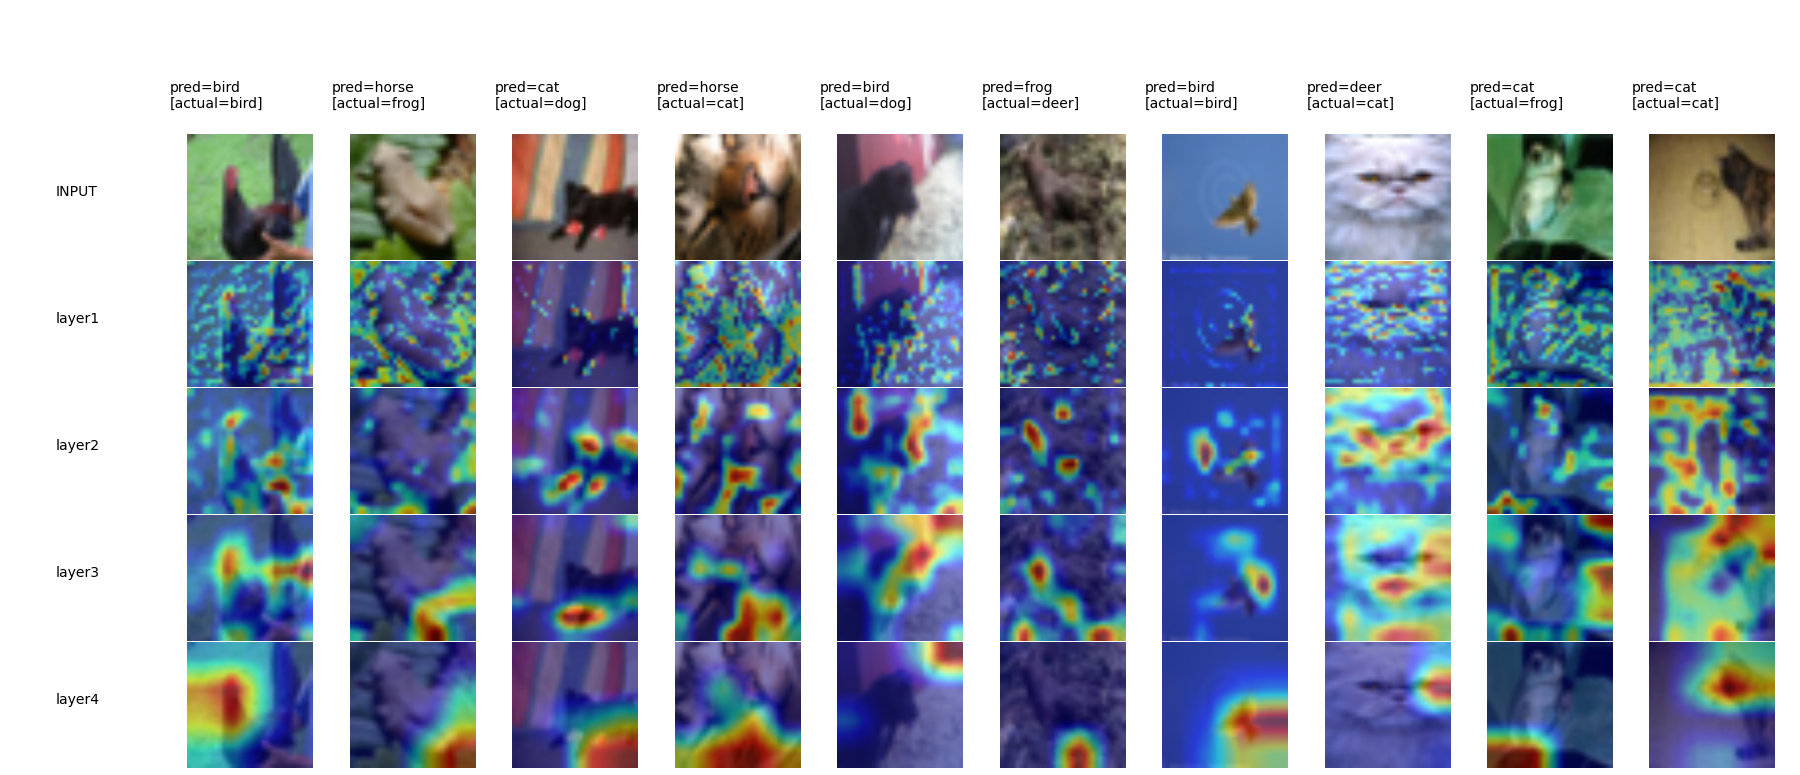

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


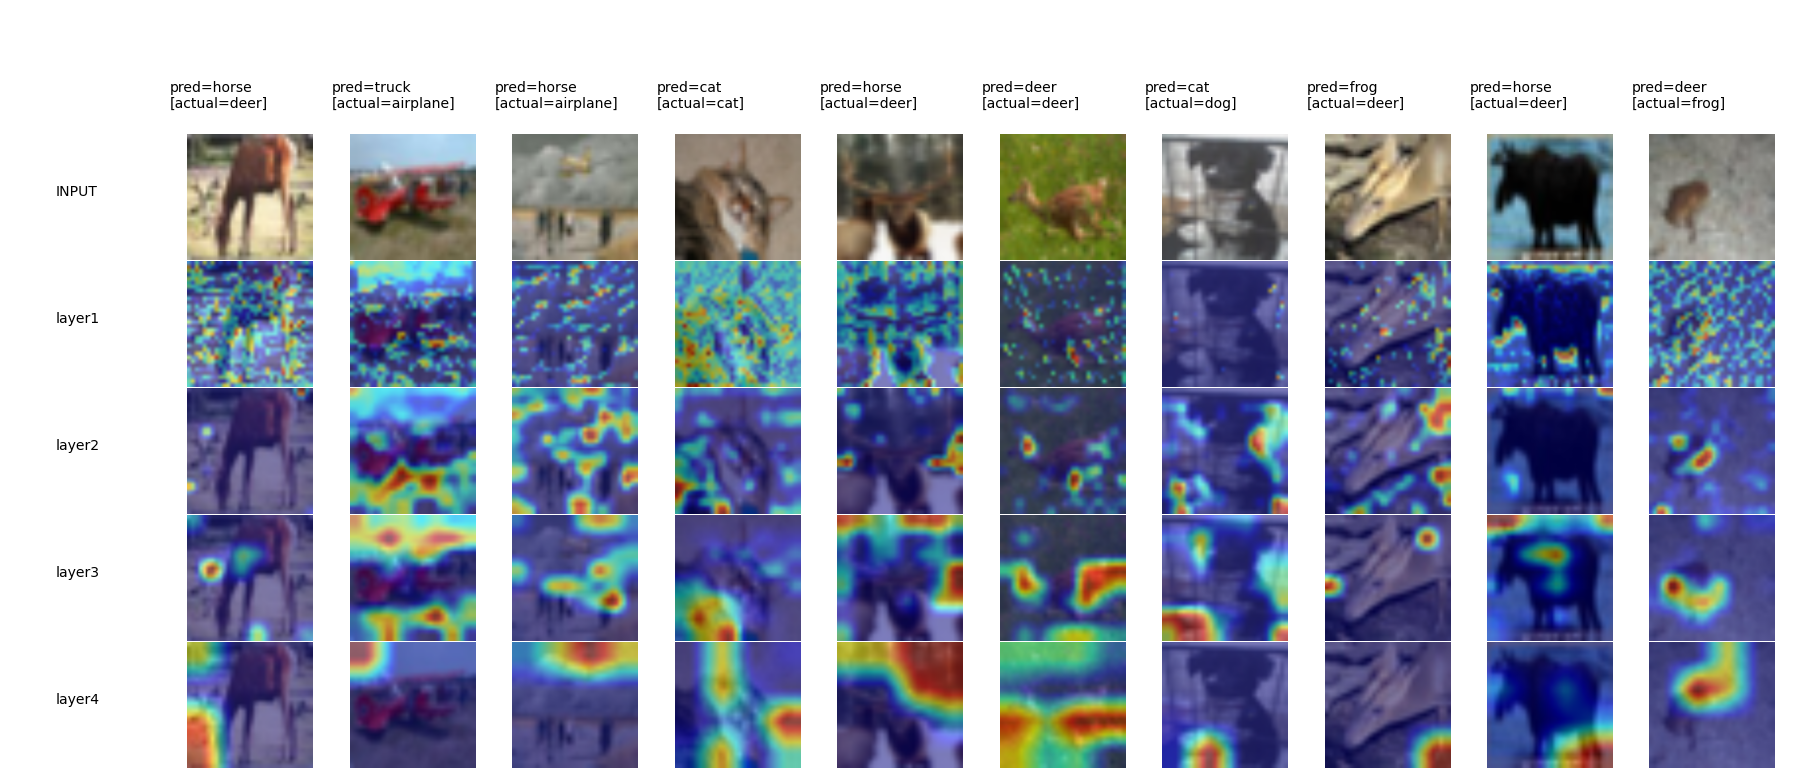

torch.Size([5, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


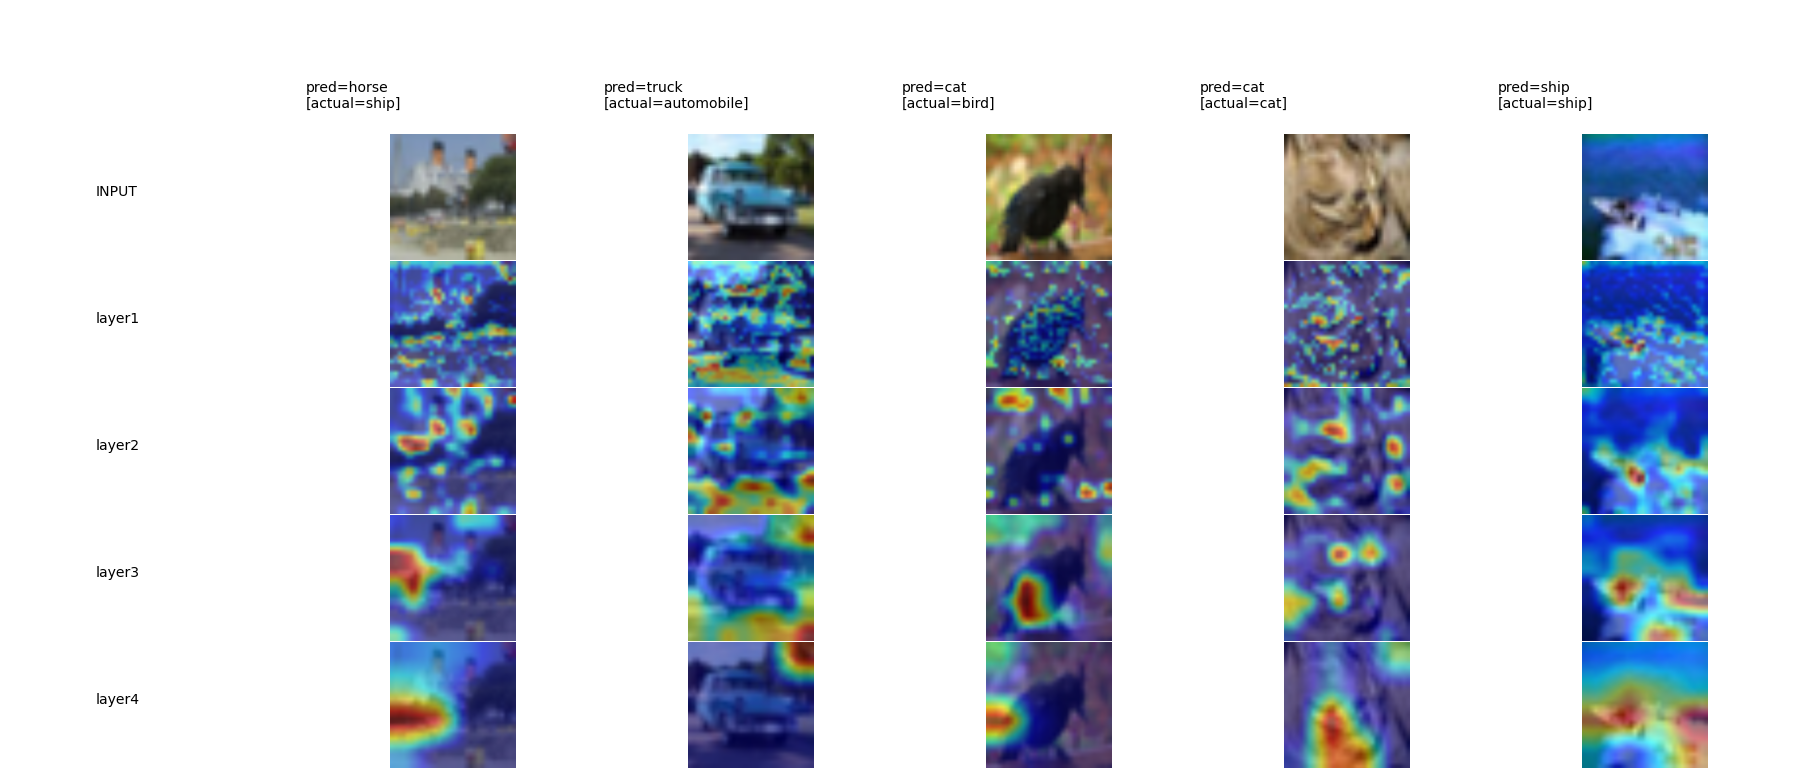

In [103]:
from gradcam import GRADCAM, PLOT
target_layers = ["layer1", "layer2", "layer3", "layer4"]
#Gradcam plot for first 10 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[:10], target_classes[:10], model, target_layers)
PLOT(gradcam_output, images[:10], target_classes[:10], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)
#Gradcam plot for 11-20 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[10:20], target_classes[10:20], model, target_layers)
PLOT(gradcam_output, images[10:20], target_classes[10:20], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)
#Gradcam plot for 21-25 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[20:], target_classes[20:], model, target_layers)
PLOT(gradcam_output, images[20:], target_classes[20:], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)